# Multi Classification Task

In [ ]:
#Imports and Styling
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
from PIL import Image
import os, warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
torch.backends.cudnn.benchmark = True
import math
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

# Define file paths
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
iprojection_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
ireport_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"

projections = pd.read_csv(iprojection_dir)
reports     = pd.read_csv(ireport_dir)



In [ ]:
# Cell 2: Data Loading and Preprocessing
# --- Function to find the first image file corresponding to a UID ---
def find_image_path(uid, image_dir):
    """Finds the path for a frontal image given a UID."""
    for filename in os.listdir(image_dir):
        if filename.startswith(str(uid) + '_'):
            return filename
    return None

# --- Load the main report CSV ---
try:
    df = pd.read_csv(ireport_dir)
except FileNotFoundError:
    print("FATAL: 'indiana_reports.csv' not found. Please ensure the file is in the correct directory.")
    exit()

image_directory = image_dir

# --- Create the image_path column ---
print("Mapping UIDs to image files. This might take a moment...")
df['image_path'] = df['uid'].apply(lambda uid: find_image_path(uid, image_directory))
df.dropna(subset=['image_path'], inplace=True)
print(f"Found and linked {len(df)} images.")

# --- Label Extraction from Text ---
df['text'] = df['impression'].fillna('') + ' ' + df['findings'].fillna('')


Mapping UIDs to image files. This might take a moment...
Found and linked 3851 images.


In [ ]:
# Cell 3: Label Creation
# --- Define diseases and keywords ---
disease_keywords = {
    'Atelectasis': ['atelectasis', 'atelectatic'],
    'Cardiomegaly': ['cardiomegaly', 'enlarged heart', 'cardiac silhouette is enlarged'],
    'Effusion': ['effusion', 'pleural fluid'],
    'Pneumonia': ['pneumonia', 'consolidation', 'infiltrate', 'airspace disease'],
    'No Finding': ['no acute', 'normal', 'clear', 'negative']
}
# Create one-hot encoded labels
for disease, keywords in disease_keywords.items():
    df[disease] = df['text'].str.contains('|'.join(keywords), case=False).astype(int)

# Refine 'No Finding'
disease_columns = list(disease_keywords.keys())
disease_columns.remove('No Finding')
df['No Finding'] = (df[disease_columns].sum(axis=1) == 0).astype(int)


# --- Final DataFrame for the Dataset ---
label_cols = list(disease_keywords.keys())
final_df = df[['image_path'] + label_cols].reset_index(drop=True)

print("\nSample of the final processed DataFrame:")
print(final_df.head())
print(f"\nNumber of classes: {len(label_cols)}")



Sample of the final processed DataFrame:
                  image_path  Atelectasis  Cardiomegaly  Effusion  Pneumonia  \
0     1_IM-0001-3001.dcm.png            0             0         1          1   
1     2_IM-0652-2001.dcm.png            0             1         0          0   
2     3_IM-1384-2001.dcm.png            0             0         1          0   
3     4_IM-2050-2001.dcm.png            0             0         1          0   
4  5_IM-2117-1003002.dcm.png            0             0         1          1   

   No Finding  
0           0  
1           0  
2           0  
3           0  
4           0  

Number of classes: 5


In [ ]:
# Cell 4: Dataset and DataLoader Creation
# --- Dataset Class ---
class ChestXrayMultiLabelDataset(Dataset):
    """Chest X-ray Multi-Label Dataset"""
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.labels = dataframe.columns[1:]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image file not found at {img_path}. Returning a dummy sample.")
            return torch.zeros((3, 224, 224)), torch.zeros(len(self.labels))

        multi_hot_labels = torch.FloatTensor(self.dataframe.iloc[idx, 1:].values.astype(float))

        if self.transform:
            image = self.transform(image)
        return image, multi_hot_labels

# --- Data Augmentation  ---
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Create the full dataset (initially with validation transform) ---
full_dataset = ChestXrayMultiLabelDataset(dataframe=final_df,
                                          root_dir=image_directory,
                                          transform=val_test_transform)

# --- Split into Train, Validation, and Test sets (70/15/15) ---
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# --- Apply the augmentation transform only to the training set ---
train_dataset.dataset.transform = train_transform

# --- Create DataLoaders ---
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



DataLoaders created:
Train dataset size: 2695
Validation dataset size: 577
Test dataset size: 579


In [ ]:
# --- Setup device ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")



Using device: cuda:0


In [ ]:
# Cell 6: Model Setup (ResNet18)
# --- Model Setup (ResNet18) ---
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# --- Get the number of input features from the final layer, which is named 'fc' in ResNet ---
num_ftrs = model.fc.in_features
num_classes = len(label_cols)

# --- the final 'fc' layer with a new one including Dropout ---
model.fc = nn.Sequential(
    nn.Dropout(p=0.3), # Add dropout with a 30% probability
    nn.Linear(num_ftrs, num_classes)
)

model = model.to(device)

# --- Calculate Class Weights for Weighted Loss Function ---
label_counts = final_df[label_cols].sum()
pos_weight = (len(final_df) - label_counts) / label_counts
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float).to(device)
print("\nCalculated positive weights for loss function to handle class imbalance.")

# --- Loss Function and Optimizer ---
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# --- the optimizer ---
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)

# --- Learning Rate Scheduler ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 



Calculated positive weights for loss function to handle class imbalance.


In [ ]:
# Cell 7: Training and Testing Functions
# --- Training and Validation Loop to return history ---
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20):
    # --- History lists to store loss values ---
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Step the scheduler based on validation loss
        scheduler.step(epoch_val_loss)

    # --- Return the history ---
    return history

# --- Final Testing Function to return results ---
def test_model_multilabel(model, criterion, test_loader):
    print("\n--- Evaluating on Test Set ---")
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            all_labels.append(labels.cpu())
            all_outputs.append(torch.sigmoid(outputs).cpu())

    final_loss = running_loss / len(test_loader.dataset)
    print(f"Final Test Loss: {final_loss:.4f}")

    # Concatenate all batches
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Calculate AUROC for each class
    print("\n--- Area Under ROC Curve (AUROC) ---")
    try:
        auroc_per_class = roc_auc_score(all_labels, all_outputs, average=None)
        for i, auroc in enumerate(auroc_per_class):
            print(f"AUROC for {label_cols[i]}: {auroc:.4f}")

        macro_auroc = roc_auc_score(all_labels, all_outputs, average='macro')
        print(f"\nMacro Average AUROC: {macro_auroc:.4f}")
    except ValueError as e:
        print(f"Could not calculate AUROC. Error: {e}")
        print("This can happen if a class is not present in the test set.")

    # --- Return labels and outputs for further analysis ---
    return all_labels, all_outputs

In [ ]:
# Cell 8: Training and Evaluation Execution
# --- Start Training ---
print("\n--- Starting Model Training ---")
# Capture the history object returned by the training function
training_history = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

# --- Final Evaluation ---
# Capture the labels and outputs for visualization
test_labels, test_outputs = test_model_multilabel(model, criterion, test_loader)


--- Starting Model Training ---
Epoch 1/10 | Train Loss: 0.9431 | Val Loss: 0.9422
Epoch 2/10 | Train Loss: 0.9009 | Val Loss: 0.9039
Epoch 3/10 | Train Loss: 0.8844 | Val Loss: 0.9089
Epoch 4/10 | Train Loss: 0.8652 | Val Loss: 0.8990
Epoch 5/10 | Train Loss: 0.8624 | Val Loss: 0.8929
Epoch 6/10 | Train Loss: 0.8480 | Val Loss: 0.8928
Epoch 7/10 | Train Loss: 0.8510 | Val Loss: 0.8952
Epoch 8/10 | Train Loss: 0.8489 | Val Loss: 0.8867
Epoch 9/10 | Train Loss: 0.8353 | Val Loss: 0.8901
Epoch 10/10 | Train Loss: 0.8320 | Val Loss: 0.8921

--- Evaluating on Test Set ---
Final Test Loss: 0.8696

--- Area Under ROC Curve (AUROC) ---
AUROC for Atelectasis: 0.6864
AUROC for Cardiomegaly: 0.7696
AUROC for Effusion: 0.5588
AUROC for Pneumonia: 0.5451
AUROC for No Finding: 0.5933

Macro Average AUROC: 0.6306




--- Training & Validation Loss Curves ---


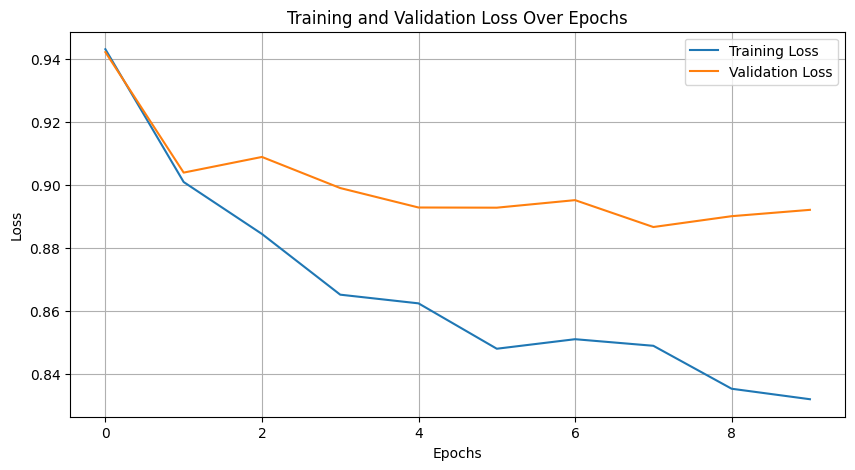

In [ ]:
# Cell 9: Visualization 1: Training & Validation Loss Curves
# --- Function to plot training curves ---
def plot_loss_curves(history):
    """Plots the training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the curves
print("\n\n--- Training & Validation Loss Curves ---")
plot_loss_curves(training_history)




--- Confusion Matrix for Each Class ---


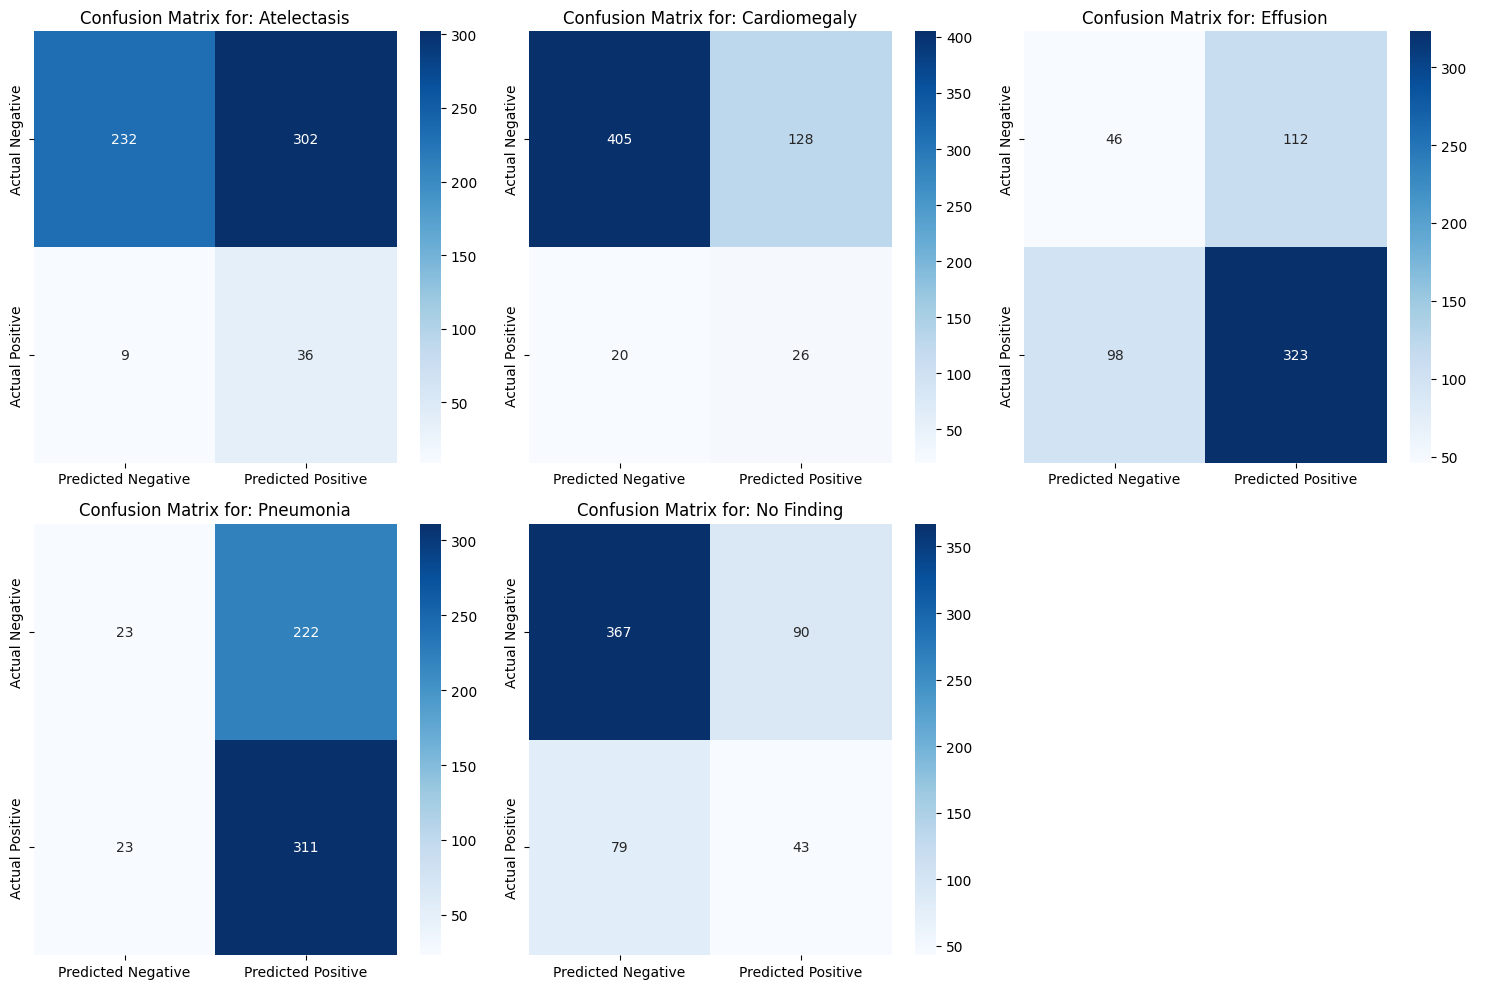

In [ ]:
# Cell 10: Visualization 2: Confusion Matrix for Each Class
# --- Function to plot confusion matrices ---
def plot_confusion_matrices(true_labels, pred_probs, class_labels, threshold=0.5):
    """
    Plots a confusion matrix for each class in a multi-label setting.
    """
    # Convert probabilities to binary predictions based on a threshold
    pred_labels = (pred_probs > threshold).astype(int)

    # Calculate the confusion matrix for each class
    mcm = multilabel_confusion_matrix(true_labels, pred_labels)

    num_classes = len(class_labels)
    rows = (num_classes + 2) // 3 # Adjust for a 3-column layout
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    for i, (matrix, label) in enumerate(zip(mcm, class_labels)):
        ax = axes[i]
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        ax.set_title(f"Confusion Matrix for: {label}")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot the matrices using the results from the test function
print("\n\n--- Confusion Matrix for Each Class ---")
plot_confusion_matrices(test_labels, test_outputs, label_cols)




--- Example Predictions on Random Test Images ---


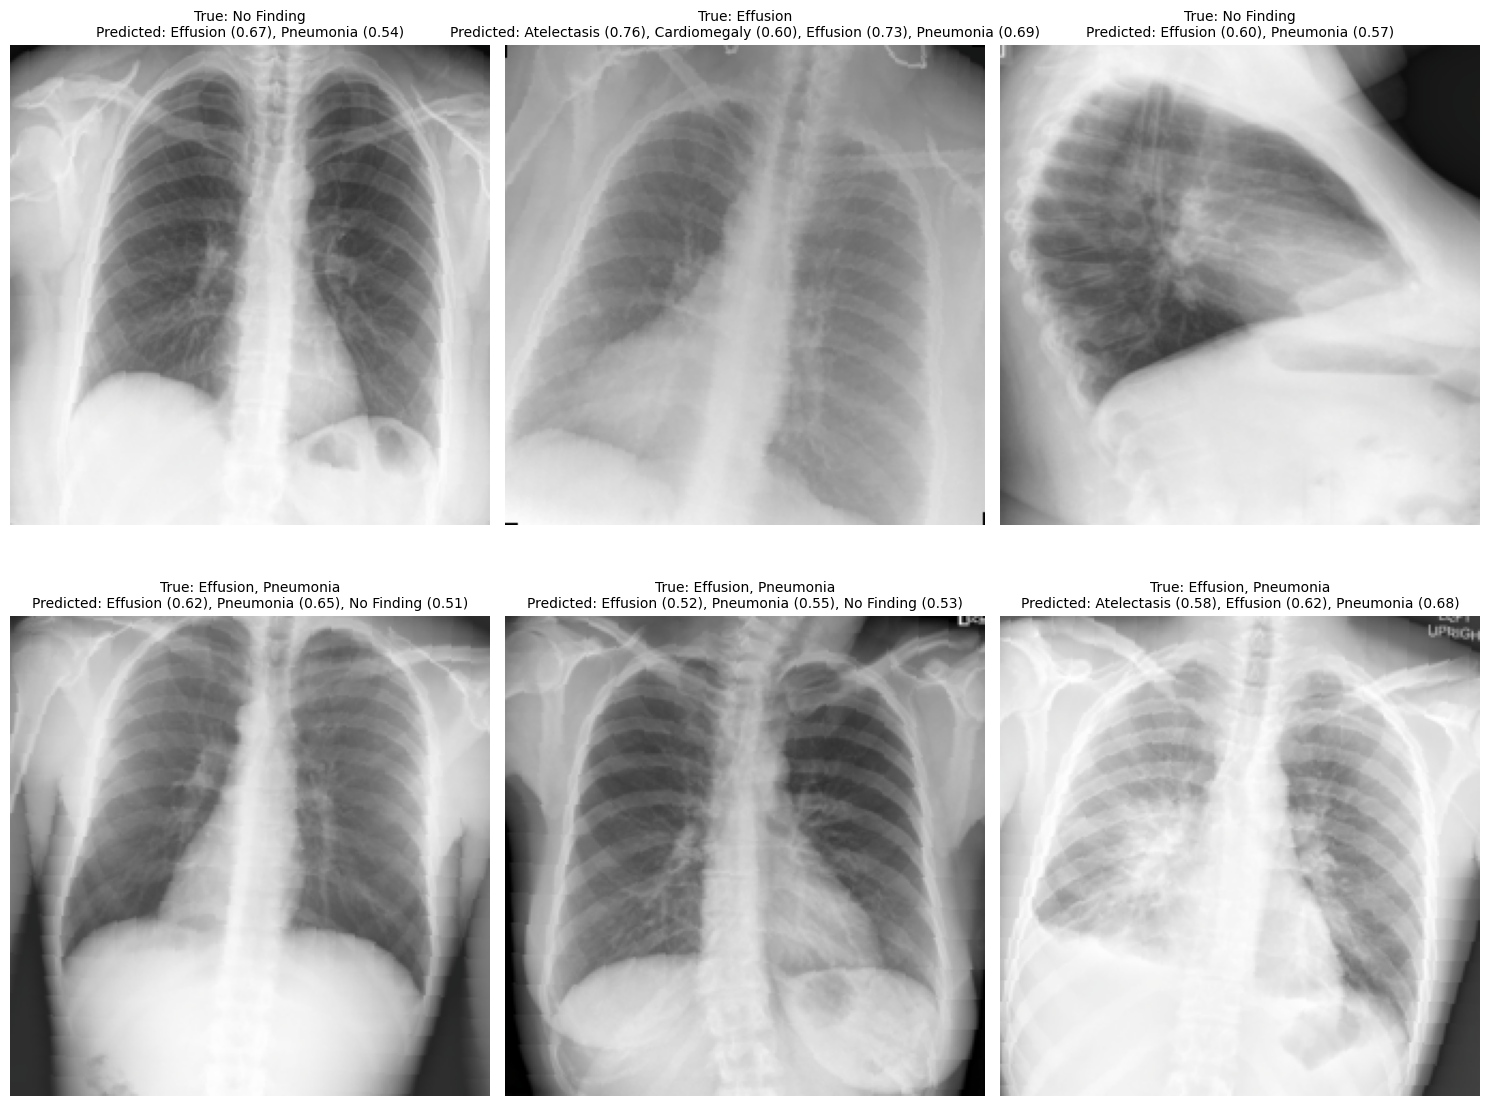

In [ ]:
# Cell 11: Visualization 3: Example Predictions on Test Images
# --- Function to visualize model predictions ---
def visualize_predictions(dataset, model, class_labels, num_images=6):
    """
    Shows a few test images and compares their true labels with model predictions.
    """
    model.eval()
    device = next(model.parameters()).device

    rows = (num_images + 2) // 3
    cols = 3
    plt.figure(figsize=(15, rows * 6))

    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = torch.sigmoid(model(image_tensor)).cpu().squeeze()

        true_labels = [class_labels[j] for j, val in enumerate(label) if val == 1]
        pred_labels = [f"{class_labels[j]} ({output[j]:.2f})" for j, val in enumerate(output) if val > 0.5]

        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_display = inv_normalize(image)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img_display.permute(1, 2, 0))
        ax.set_title(f"True: {', '.join(true_labels) or 'No Finding'}\nPredicted: {', '.join(pred_labels) or 'No Finding'}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions from the test set
print("\n\n--- Example Predictions on Random Test Images ---")
visualize_predictions(test_dataset, model, label_cols)